# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Data is the dictionary that contains all the datasets. The key of the dictionary 
# is the name of the file(without the csv extension) and the value is the 
# file with the extension. Each individual dataset is a Panda DataFrame
data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
# Filter for the columns that are relevant for the analysis
survey = survey.loc[:,survey_fields] 
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]
# The datasets will combine together with the DBN column that is the identification
# of each school. For this purpose is necessary to make the column DBN in the 
# class_size dataset. In this dataset the combination of the columns CSD and SCHOOL CODE result in the
# DBN column. First I start to add a '0' in the CSD column and then to combine both.
def pad_csd(num): 
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")
# the keyword argument errors='coerce' allow that any invalid string that can't be converted to numbers
# are instead treated as missing values.
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Need to parse the coordinates for each school. This will enable to map out each school and find
# any geographic pattern. With regular expression I pull out everything inside the parentheses and 
# extract the latitud and longitud for each school. 
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# Condense the dataset by groupby to make a unique row of the DBN value in the class_size DataFrame
# For this puropose I use the aggregate method in order to calculate the mean of each numeric column in the DataFrame
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# Condense the datasets demographics and graduation to enable both dataset to have a unique value
# in the DBN column
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

# I will merge all the dataset with combined. At the end, combined will have 
# all of the columns from all of the datasets.
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]
# Inner join, combine rows of both dataset that have the same DBN.
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
# Add a column that specify the school district to the datset
# In this function, I use indexing to extract the first 2 characters of th DBN column
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

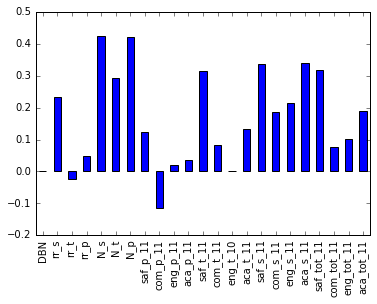

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline 
# bar plot of the correlation between the survey_fields and sat_score
combined.corr()["sat_score"][survey_fields].plot(kind='bar')
plt.show()

It possible to observe that the N_s(Number of student respondent) and N_p (Number of parents respondent) variables are those with the highest correlation with sat_score. The Number of student respondent and the Number of parents respondent have a correlation above of 0.4 with the sat_score.

This fact could be explained as if the students who answer the survey are those that are more interested in achieve better marks than those that don't respond the survey. 

In the other hand, the unique variable that hold a negative relation with sat_score is com_p_11(communication score bases on parent responses). 

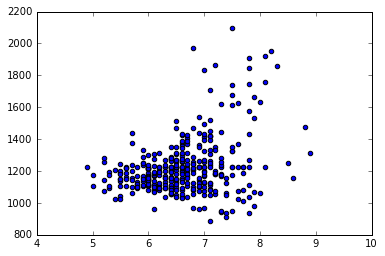

In [11]:
# Make a scatterplot of the saf_s_11 column vs the sat_score in combined
plt.scatter(combined['saf_s_11'],combined['sat_score'])

The graphic show that there are a posite correlation between saf_s_11  and sat_core. This is reasonble because as more safety is the school, more comfortable the students are, and is more likely to perform well at school.
Nevertheless there are a cluster of points in the centre of the graphic that appear to have a negative or neutral correlation between the safety and the sat_results. 

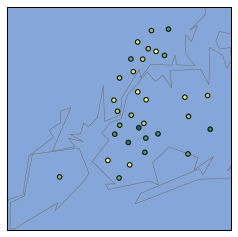

In [12]:
import numpy as np 
# Map out safety scores by district
# Compute the average safety score for each district
# In the first step, I calculate the mean values of all the numeric variables in the 
# combined Data Frame, that have a unique value of school_dist.
# With this transformation I agruped the dataset by district and calculate
# the mean value of each numeric variable in the combined Data Frame.
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)


# Make a map that shows safety scores by district

# I use the matplotlib package on Basemap to plot the safety scores by district
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()





The map plot show that in the 3 areas of NY such as Manhattan, Queen and Bronx, we can find some difference among the areas. While the number of districts whith high safety scores are well balance in Queen and Manhattan. This is not the case if we observe Brooklin where there is a big number of distritct that have worst safety scores in schools. 

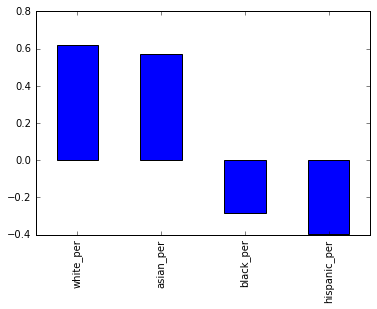

In [13]:
# Make a scatterplot to investigate if there are racial differences
# in SAT scores.
# For this purpose I make a scatterplot of the correlations betwen the racial 
# type and the variable sat_score. 

list_columns = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][list_columns].plot(kind='bar')
plt.show()


The bar plot of the correlations between racial variables and sat_score, show that white_per and asian_per have a strong correlation with sat_score with around 0.6 level. This means that as more the presence of white and asian students in  schools, better will be the marks in this exam. 

In the other hand the hispanic_per and black_per variables have a negative correlation with sat_score. This fact show that while less is the percentage of black and hispanic students in schools, better will be the sat results.   

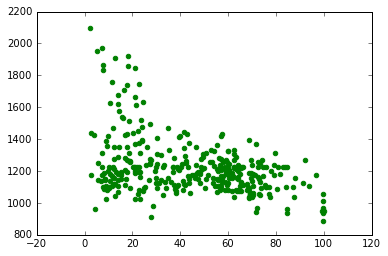

In [14]:
# In this step I explore the relationship between hispanic_per and sat_scores.
# Make a scatterplot of hispanic_per vs sat_score 
plt.scatter(combined['hispanic_per'],combined['sat_score'], color='green')
plt.show()

There is a negative correlation between those variables. This could be explain as if while the presence of hispanic go up, the sat_score will be less. In the same line,the sat_score go up in the school with less presence of hipanic people. 

I conclude that there are a big amount of hispanic student thate aren't well prepared to take the sat exam. 

In [15]:
# Reaserch the schools with a greater than 95% of hipanic_per
# For this purpose, I filter the data frame by the rows with values in hispanic_per column greater than 95%
hisp_grt_95 = combined[combined['hispanic_per'] > 95]
print(hisp_grt_95['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [16]:
# Find schools with less than 10% of hispanic_per and greater than
# 1800 average SAT score.
hisp_less_10 = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
print(hisp_less_10['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools are specialized in the science and technical areas, and seems to have high standard of admission. That involve that the admission is highly competitive and so on students in these schools have high academic performance. 

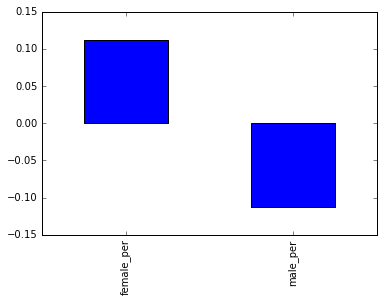

In [17]:
# In this step, I investigate gender differences in SAT score.
# I write the labels of the column and then pass this, into the bar function

gender = ['female_per','male_per']
combined.corr()['sat_score'][gender].plot(kind='bar')
plt.show()

There are a positive correlation between female_per and sat_score and a negative correlation between male_per and sat_score. This reflect that the precense of females in  schools will be a clue for better scores in the sat exam than the precense of males. 

In contrast the presence of males, will generate worst result in the SAT exam.

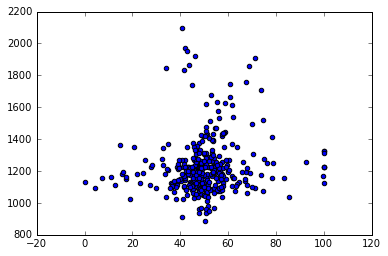

In [18]:
# In this step I examine the relation between female_per and sat_score
plt.scatter(combined['female_per'],combined['sat_score'])

The scatter plot show a weak positive correlation between female_per and sat_score variables. 
There are a cluster of points at the level of 50% of female in schools, showing up that a great number of womans takes scores between 1000 and 1400 in the sat test.

In [19]:
# Schools with a greater than 60% female_per and greater than 1700 average SAT score.
var = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
      
print(var['School Name'])

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object


These school are known for the highly standard of admission, in which a small group of selected students could achieve the admission process. Also these schools have a ratio of students-teachers that is above of the mean. 
That could be the cause of the well preparation of the students and the high marks in the SAT exam.

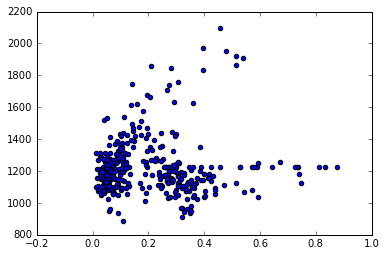

In [20]:
# In this part, I will compute the percentage of students in each school that took the AP exam.
# For this, I generate the ap_per column that yield the percentage of students in each 
# school that took the AP exam
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
plt.scatter(combined['ap_per'],combined['sat_score'])

The scatterplot show that for the whole sample there are not a clear relationship between the ap_per and sat_score variables. However we can note a clear relationship between thse two variables for those schools with students marks in the SAT exam that are above the threshold of 1400 points.

Below the 1400 points in the SAT score, there are schools that have students with the same level in the sat_score variable but the percentage of those that take the AP Test vary a lot among these schools.

In [21]:
# In this step I will investigate the relationship between class size and SAT scores
# Firslty I analysed the variables in the class_size DataFrame, and pick some of them
# that are intereting to observe
print(class_size.columns)


Index(['DBN', 'CSD', 'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS',
       'SCHOOLWIDE PUPIL-TEACHER RATIO'],
      dtype='object')


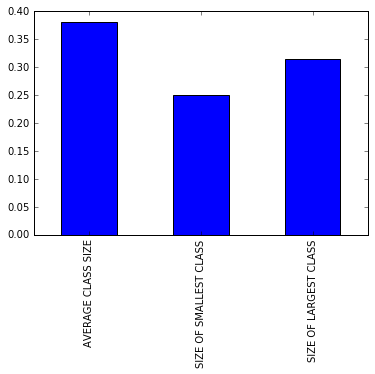

In [22]:
# I will analyse the relationship between sat_scores, and the following
# variables: Average Class Size, Size of smallest class, size of largest class
size = ['AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS']
combined.corr()['sat_score'][size].plot(kind='bar')

The three variables(AVERAGE CLASS SIZE, SIZE OF SLMALLEST CLASS and SIZE OF LARGEST CLASS) have a positive correlation with sat_scores variable. Within the sizes, it is possible to appreciate that as more large is the size of the class more will be the performance on sat_scores exam in comparison with the smallest class size.

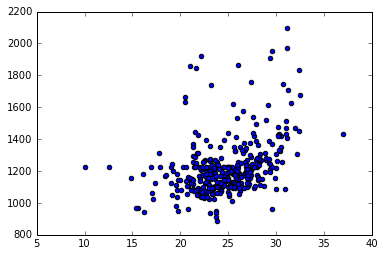

In [23]:
# The next plot analyse the relation between 'AVERAGE CLASS SIZE'
# and sat_score
plt.scatter(combined['AVERAGE CLASS SIZE'],combined['sat_score'])

The scatter plot between AVERAGE CLASS SIZE and sat_score show a positive correlation between both variables. 

It will be interesting to find out the areas with better school performance.
A way to accomplish this, is to map the districts with better and worst performance based on the mean score of the SAT exam in each district.

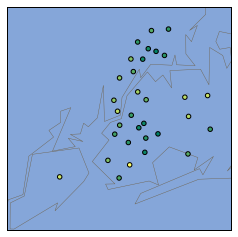

In [24]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts["sat_score"], cmap="summer")
plt.show()

# the c parameter is the relevant variable in which the map is divided.

The map ilustrated with yellow points, the areas of NY with best school performance. These areas are mainly in Queens where there are 3 yellow point.
In the other hand, Brooklin is the area where there are more green point, that means that we can find poor school performance in this area.


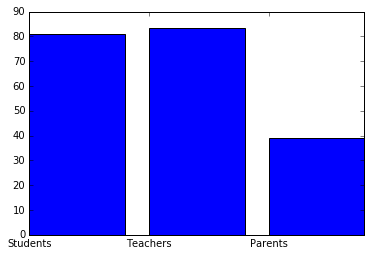

In [25]:

# In this step I will look into the differences between parent, teacher and student responses to 
# surveys
# In first place, the analysis go thorought the observation of the rate of 
# responses between students, parents and teachers. 

x = np.arange(3)
rate_respondents = combined[['rr_s','rr_t','rr_p']].mean()
labels = ['Students','Teachers','Parents']
plt.xticks(x,labels)

plt.bar(x,rate_respondents)
plt.show()

        





The bar show the means of the responses of Students, Teachers and Parents. Students and Teachers have a high rate of responses, while Parents has the lowest rate with almost 40%. 
We can interpret this as if some parents are not well involucrated in the school affairs.

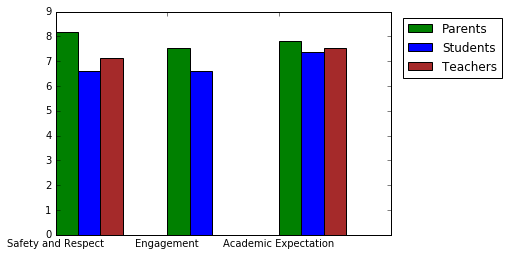

In [26]:
# Secondly,I will analyse the variables safety and respect score,engagement score and
# academic expectation based on parents, student and teacher responses
n_variables = np.arange(3)
n_variables1 = np.arange(3)
n_variables2 = np.arange(3)
parent_responses = combined[['saf_p_11','eng_p_11','aca_p_11']].mean()
student_responses = combined[['saf_s_11','eng_s_11','aca_s_11']].mean()
teacher_responses = combined[['saf_t_11','eng_t_10','aca_t_11']].mean()
bar_1 = plt.bar(n_variables,parent_responses,0.2,color='green')
bar_2 = plt.bar(n_variables + 0.2,student_responses,0.2,color='blue')
bar_3 = plt.bar(n_variables + 0.4,teacher_responses,0.2,color='brown')
names = ['Safety and Respect','Engagement','Academic Expectation']
plt.xticks(n_variables,names)
plt.legend((bar_1, bar_2, bar_3), ("Parents", "Students", "Teachers"),bbox_to_anchor=(1.35, 1))
plt.show()


The results of this bar shows that Parents assign a higher score in the variables Safety and Respect, Engagement and Academic Expectation than those that assign teachers and students.
These result could be interpreted as if parents are more comfortable in these features in relation with students and teachers. 

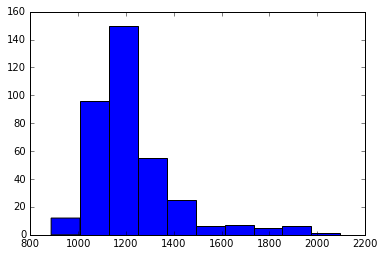

(363, 161)

In [27]:
# In order to dive into the distribution of sat_score variable, I plot 
# a histogram to observe the concentration of the values.
plt.hist(combined['sat_score'])
plt.show()
combined.shape

In this stage, I will carry an analysis about the schools with
the aim of assign a score to each school based on sat_score. 
I generate the ranking_school column with the values : High Score, Medium Score and Poor Score according to the result in the SAT score test.



In [45]:
# Create a function to classify the students among high score, medium score
# or poor score according to the sat_score column
def score(row): 
    mark= row['sat_score']
    if mark >= 1500:
        return 'High score'
    elif (mark > 1100) and (mark < 1500):
        return 'Medium score'
    elif mark <=1100:
        return 'Poor score'  
print(combined.columns)
combined['ranking_school'] = combined.apply(score,axis=1)
# Display schools with High and Medium score
print(combined[combined['ranking_school']== 'High score']['SCHOOL NAME'])
print(combined[combined['ranking_school']== 'Poor score']['SCHOOL NAME'])


Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority07', 'priority08', 'priority09', 'priority10', 'Location 1',
       'lat', 'lon', 'school_dist', 'ap_per', 'ranking_school'],
      dtype='object', length=162)
4      NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...
5                         BARD HIGH SCHOOL EARLY COLLEGE
22              PROFESSIONAL PERFORMING ARTS HIGH SCHOOL
23                     BARUCH COLLEGE CAMPUS HIGH SCHOOL
24           N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES
26                         ELEANOR ROOSEVELT HIGH SCHOOL
27                                MILLENNIUM HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
79     HIGH SCHO